# Naive stock movement prediction
- In this notebook, we try to make a naive prediction of the direction of movement of AAPL using different ML classifiers. 
- We are using a classifier like Random Forest because of the binary nature of prediciton: $1=$stock price will go up the next day and $0=$stock price will not go up the next day.  
- Strategy is to buy stock if the stock price will go up the next day (or the we predict $1$ for a day).  
- We will use precision to track the error. __Precision__ is the __(#true positive)/(#true potsitive + #false positive)__. High precision means that we have a small chancing of predicting false positives. In our strategy, this is important since a flase +ve can lead to money loss. This means we allow false negatives since this does not cause any money loss (even though we may make less profit because of this). 
- The ratio __(#true negative)/(#true negative + #false negative)__ is called __recall__. In our application, we are fine with a lower recall, since it is not going to cause any extra loss. 

### Downloading apple stock price history from MSFT

In [71]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [43]:
if os.path.exists("apple_data.json"):
    aapl_hist = pd.read_json("apple_data.json")
else:
    aapl = yf.Ticker("AAPL")
    aapl_hist = aapl.history(period="max")
    aapl_hist.to_json("apple_data.json")    

In [44]:
aapl_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1980-12-12,0.100178,0.100614,0.100178,0.100178,469033600,0.0,0
1980-12-15,0.095388,0.095388,0.094952,0.094952,175884800,0.0,0
1980-12-16,0.088418,0.088418,0.087983,0.087983,105728000,0.0,0
1980-12-17,0.090160,0.090596,0.090160,0.090160,86441600,0.0,0
1980-12-18,0.092774,0.093210,0.092774,0.092774,73449600,0.0,0
...,...,...,...,...,...,...,...
2022-05-16,145.550003,147.520004,144.179993,145.539993,86643800,0.0,0
2022-05-17,148.860001,149.770004,146.679993,149.240005,78336300,0.0,0
2022-05-18,146.850006,147.360001,139.899994,140.820007,109742900,0.0,0
2022-05-19,139.880005,141.660004,136.600006,137.350006,136095600,0.0,0


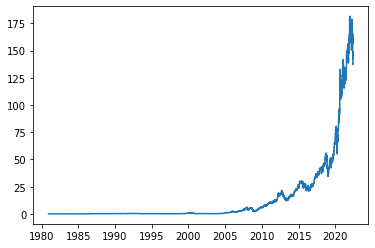

In [48]:
plt.plot(aapl_hist.index, aapl_hist["Close"])

### Using shift to achieve a lag and calculate the return

In [53]:
aapl_hist["Return"] = aapl_hist['Close'] - aapl_hist['Close'].shift(1)
aapl_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return
1980-12-12,0.100178,0.100614,0.100178,0.100178,469033600,0.0,0,NaN
1980-12-15,0.095388,0.095388,0.094952,0.094952,175884800,0.0,0,-0.005226
1980-12-16,0.088418,0.088418,0.087983,0.087983,105728000,0.0,0,-0.006969
1980-12-17,0.090160,0.090596,0.090160,0.090160,86441600,0.0,0,0.002178
1980-12-18,0.092774,0.093210,0.092774,0.092774,73449600,0.0,0,0.002614
...,...,...,...,...,...,...,...,...
2022-05-16,145.550003,147.520004,144.179993,145.539993,86643800,0.0,0,-1.570007
2022-05-17,148.860001,149.770004,146.679993,149.240005,78336300,0.0,0,3.700012
2022-05-18,146.850006,147.360001,139.899994,140.820007,109742900,0.0,0,-8.419998
2022-05-19,139.880005,141.660004,136.600006,137.350006,136095600,0.0,0,-3.470001


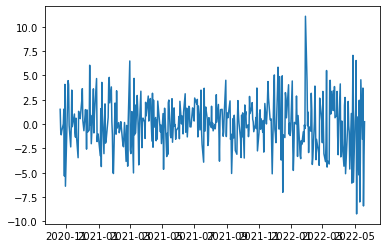

In [57]:
plt.plot(aapl_hist.index[-400:], aapl_hist["Return"][-400:])

(array([ 1.,  0.,  1.,  1.,  0.,  1.,  0.,  2.,  1.,  2.,  7.,  4.,  6.,
         9., 12., 10.,  7.,  9., 18., 20., 28., 30., 34., 34., 29., 19.,
        24., 12., 17., 11.,  8., 12.,  9.,  9.,  5.,  1.,  1.,  2.,  2.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-9.23641968, -8.83009949, -8.4237793 , -8.01745911, -7.61113892,
        -7.20481873, -6.79849854, -6.39217834, -5.98585815, -5.57953796,
        -5.17321777, -4.76689758, -4.36057739, -3.9542572 , -3.54793701,
        -3.14161682, -2.73529663, -2.32897644, -1.92265625, -1.51633606,
        -1.11001587, -0.70369568, -0.29737549,  0.1089447 ,  0.51526489,
         0.92158508,  1.32790527,  1.73422546,  2.14054565,  2.54686584,
         2.95318604,  3.35950623,  3.76582642,  4.17214661,  4.5784668 ,
         4.98478699,  5.39110718,  5.79742737,  6.20374756,  6.61006775,
         7.01638794,  7.42270813,  7.82902832,  8.23534851,  8.6416687 ,
         9.04798889,  9.45430908,  9.86062927, 10.26694946,

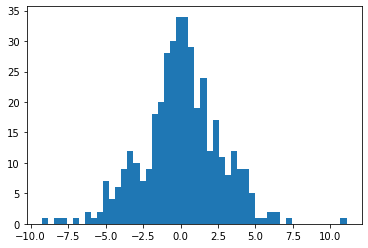

In [84]:
plt.hist(aapl_hist["Return"][-400:], bins=50)

### Checking for normality using Kolmogrov-Smirnov test

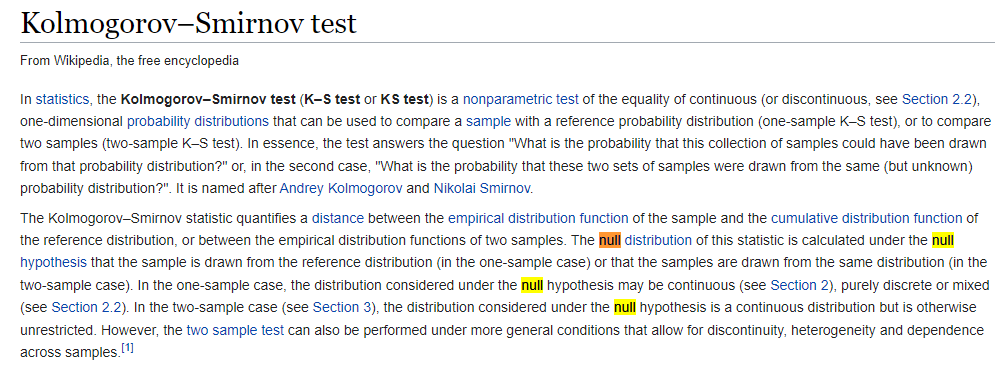

In [67]:
from scipy import stats

#### Testing for normal dist

In [82]:
np.random.uniform(0,1, 10000).reshape((100,100))
stats.kstest(np.random.normal(0,1, 10000), 'norm')

KstestResult(statistic=0.012157825566376623, pvalue=0.10316956645659625)

#### Testing for our stock returns.

- Null hypothesis is that the underlying dist is same as the given dist.
- if p<0.05, we reject teh null hypothesis and we conclude that they are not the same dit.
- In our case, since the return of the stock has small p value, we conclude that the return of stock prices are not normally distributed. 

In [90]:
stats.kstest(aapl_hist["Return"][-400:], cdf="norm")

KstestResult(statistic=0.2060641616439186, pvalue=2.2571740035287587e-15)

### Preparing data

In [265]:
#Creating a df with actual close price
data = pd.DataFrame()
data[['Real Close', 'Return']] = aapl_hist[['Close', 'Return']]
data['Target'] = data.rolling(2).apply(lambda x: x[1] > x[0])["Real Close"]
data['Confirm Target'] = data["Return"].apply(lambda x: float(x>0)) #RHS same as data["Return"]>0

In [266]:
data

,Real Close,Return,Target,Confirm Target
1980-12-12,0.100178,NaN,NaN,0.0
1980-12-15,0.094952,-0.005226,0.0,0.0
1980-12-16,0.087983,-0.006969,0.0,0.0
1980-12-17,0.090160,0.002178,1.0,1.0
1980-12-18,0.092774,0.002614,1.0,1.0
...,...,...,...,...
2022-05-16,145.539993,-1.570007,0.0,0.0
2022-05-17,149.240005,3.700012,1.0,1.0
2022-05-18,140.820007,-8.419998,0.0,0.0
2022-05-19,137.350006,-3.470001,0.0,0.0


In [267]:
data.drop(columns=["Return", "Confirm Target"], inplace=True)

In [136]:
data

,Real Close,Target
1980-12-12,0.100178,NaN
1980-12-15,0.094952,0.0
1980-12-16,0.087983,0.0
1980-12-17,0.090160,1.0
1980-12-18,0.092774,1.0
...,...,...
2022-05-16,145.539993,0.0
2022-05-17,149.240005,1.0
2022-05-18,140.820007,0.0
2022-05-19,137.350006,0.0


#### Shifting the data from original price history so we don't use the same day data for prediction. We always use the data from past for prediction. 

In [140]:
aapl_hist_shift = aapl_hist.shift(1)
aapl_hist_shift

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return
1980-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.100178,0.100614,0.100178,0.100178,469033600.0,0.0,0.0,NaN
1980-12-16,0.095388,0.095388,0.094952,0.094952,175884800.0,0.0,0.0,-0.005226
1980-12-17,0.088418,0.088418,0.087983,0.087983,105728000.0,0.0,0.0,-0.006969
1980-12-18,0.090160,0.090596,0.090160,0.090160,86441600.0,0.0,0.0,0.002178
...,...,...,...,...,...,...,...,...
2022-05-16,144.589996,148.100006,143.110001,147.110001,113787000.0,0.0,0.0,4.550003
2022-05-17,145.550003,147.520004,144.179993,145.539993,86643800.0,0.0,0.0,-1.570007
2022-05-18,148.860001,149.770004,146.679993,149.240005,78336300.0,0.0,0.0,3.700012
2022-05-19,146.850006,147.360001,139.899994,140.820007,109742900.0,0.0,0.0,-8.419998


#### Joining the data with the history to get the complete data set. We also determine the predictors at this step. 
- Note that we are only using the latest 4000 data points as the data in the past may not be significant for current prediction. We could have also done some kind of exponential smoothing averages. 

In [264]:
predictors_used = ["High", "Open", "Close", "Low", "Volume", "Dividends", "Stock Splits"]

In [268]:
data = data.join(aapl_hist_shift[predictors_used]).iloc[-4000:]
data

,Real Close,Target,High,Open,Close,Low,Volume,Dividends,Stock Splits
2006-07-03,1.769582,1.0,1.763475,1.758589,1.748817,1.725304,739695600.0,0.0,0.0
2006-07-05,1.740572,0.0,1.776605,1.756451,1.769582,1.750954,194770800.0,0.0,0.0
2006-07-06,1.703013,0.0,1.758894,1.745152,1.740572,1.727136,518240800.0,0.0,0.0
2006-07-07,1.691714,0.0,1.752787,1.743321,1.703013,1.698126,633208800.0,0.0,0.0
2006-07-10,1.679499,0.0,1.726831,1.694158,1.691714,1.669423,799360800.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2022-05-16,145.539993,0.0,148.100006,144.589996,147.110001,143.110001,113787000.0,0.0,0.0
2022-05-17,149.240005,1.0,147.520004,145.550003,145.539993,144.179993,86643800.0,0.0,0.0
2022-05-18,140.820007,0.0,149.770004,148.860001,149.240005,146.679993,78336300.0,0.0,0.0
2022-05-19,137.350006,0.0,147.360001,146.850006,140.820007,139.899994,109742900.0,0.0,0.0


#### Splitting int training and testing data

In [269]:
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]

## Importing model

- We are first going to use the random forest model train a classifer to predict whether the return on next day is going to be positive or not. 

In [270]:
from sklearn.ensemble import RandomForestClassifier

In [271]:
model_1 = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

#### Fitting the model 

In [272]:
model_1.fit(data_train[predictors_used], data_train['Target'])

RandomForestClassifier(min_samples_split=200, random_state=1)

## Measuring error

- We are going to use the precision as our error metric. 
- This can be done using the precision_score function given by sklearn. 

In [273]:
from sklearn.metrics import precision_score

In [274]:
#Making predictions
preds = model_1.predict(data_test[predictors_used])
preds = pd.Series(preds, index = data_test.index)
precision_score(data_test['Target'], preds)

0.5058823529411764

#### We get a precision of 0.8333 which means we will correctly predict that out of all the positive predictions we made, we were right 83 % of the time. 

### Plotting the predictions and true value

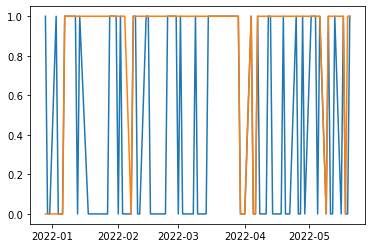

In [275]:
plt.plot(data_test["Target"])
plt.plot(preds)
plt.show()

#### We can also plot this by combining the predicted and true values into a data frame

In [276]:
combined_results = pd.concat({"Target": data_test["Target"], "Predictions": preds}, axis=1)

<AxesSubplot:>

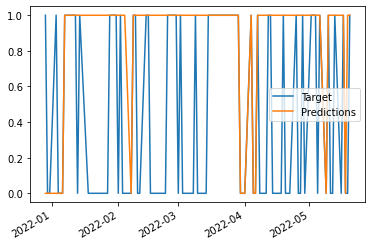

In [277]:
combined_results.plot()

#### Increasing accuracy by increasing the threshold for positives- Default is >0.5 probability. We can make it 0.6.

In [278]:
preds_increased_thresh = model_1.predict_proba(data_test[predictors_used])[:,1]
preds_increased_thresh = pd.Series(preds_increased_thresh, index = data_test.index)

In [279]:
preds_increased_thresh

2021-12-29    0.351443
2021-12-30    0.356199
2021-12-31    0.356199
2022-01-03    0.367262
2022-01-04    0.325464
                ...   
2022-05-16    0.557225
2022-05-17    0.559027
2022-05-18    0.465888
2022-05-19    0.531166
2022-05-20    0.521198
Length: 100, dtype: float64

In [280]:
preds_increased_thresh[preds_increased_thresh>0.501]

2022-01-07    0.627709
2022-01-10    0.616170
2022-01-11    0.596384
2022-01-12    0.585753
2022-01-13    0.601752
                ...   
2022-05-13    0.502765
2022-05-16    0.557225
2022-05-17    0.559027
2022-05-19    0.531166
2022-05-20    0.521198
Length: 85, dtype: float64

In [281]:
preds_increased_thresh[] = preds_increased_thresh[preds_increased_thresh>0.6]

SyntaxError: invalid syntax (2579814120.py, line 1)

## Adding moving averages to the data

### Note on df.rolling() function

- pd.df.rolling(n) function is useful when we want to find moving averages/sum with window size n. 
- For example, DF.roling(3).sum() gives the rolling sum with window size 3. This means that the first 2 rows in the DF will be Nan and from third entry onwards, it will be sum of the most recent three rows including the current row. 
- to find the moving average of window size n, use DF.rolling(n).mean().
- rolling().sum() or rolling().mean() gives a pd.dataframe. To get only one of the columns in a series form, use the Column label. Eg. rolling(3).mean()["Close"] will give a pandas series with moving average of close values of the stock with window size 3.

In [282]:
weakly_moving_av_data = data.rolling(7).mean()
quarterly_moving_av_data = data.rolling(90).mean()
yearly_moving_av_data = data.rolling(365).mean()

In [283]:
# Making a deep copy of the data
import copy
data_copy = copy.deepcopy(data)

In [284]:
data_copy

,Real Close,Target,High,Open,Close,Low,Volume,Dividends,Stock Splits
2006-07-03,1.769582,1.0,1.763475,1.758589,1.748817,1.725304,739695600.0,0.0,0.0
2006-07-05,1.740572,0.0,1.776605,1.756451,1.769582,1.750954,194770800.0,0.0,0.0
2006-07-06,1.703013,0.0,1.758894,1.745152,1.740572,1.727136,518240800.0,0.0,0.0
2006-07-07,1.691714,0.0,1.752787,1.743321,1.703013,1.698126,633208800.0,0.0,0.0
2006-07-10,1.679499,0.0,1.726831,1.694158,1.691714,1.669423,799360800.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2022-05-16,145.539993,0.0,148.100006,144.589996,147.110001,143.110001,113787000.0,0.0,0.0
2022-05-17,149.240005,1.0,147.520004,145.550003,145.539993,144.179993,86643800.0,0.0,0.0
2022-05-18,140.820007,0.0,149.770004,148.860001,149.240005,146.679993,78336300.0,0.0,0.0
2022-05-19,137.350006,0.0,147.360001,146.850006,140.820007,139.899994,109742900.0,0.0,0.0


In [285]:
weakly_moving_av_data

,Real Close,Target,High,Open,Close,Low,Volume,Dividends,Stock Splits
2006-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-05-16,149.365712,0.428571,155.085613,152.989945,150.937143,148.720380,1.332292e+08,0.032857,0.0
2022-05-17,148.217141,0.428571,152.754288,150.409999,149.365712,147.214284,1.269604e+08,0.032857,0.0
2022-05-18,146.611428,0.428571,151.372859,149.388572,148.217141,146.142855,1.215719e+08,0.000000,0.0
2022-05-19,144.160001,0.285714,150.162859,148.234288,146.611428,144.487139,1.184526e+08,0.000000,0.0


In [286]:
data_copy["Weekly_Close_Average"] = weakly_moving_av_data["Close"]
data_copy["Quart_Close_Average"] = quarterly_moving_av_data["Close"]
data_copy["Yearly_Close_Average"] = yearly_moving_av_data["Close"]

In [287]:
data_copy

,Real Close,Target,High,Open,Close,Low,Volume,Dividends,Stock Splits,Weekly_Close_Average,Quart_Close_Average,Yearly_Close_Average
2006-07-03,1.769582,1.0,1.763475,1.758589,1.748817,1.725304,739695600.0,0.0,0.0,NaN,NaN,NaN
2006-07-05,1.740572,0.0,1.776605,1.756451,1.769582,1.750954,194770800.0,0.0,0.0,NaN,NaN,NaN
2006-07-06,1.703013,0.0,1.758894,1.745152,1.740572,1.727136,518240800.0,0.0,0.0,NaN,NaN,NaN
2006-07-07,1.691714,0.0,1.752787,1.743321,1.703013,1.698126,633208800.0,0.0,0.0,NaN,NaN,NaN
2006-07-10,1.679499,0.0,1.726831,1.694158,1.691714,1.669423,799360800.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,145.539993,0.0,148.100006,144.589996,147.110001,143.110001,113787000.0,0.0,0.0,150.937143,165.733093,145.939584
2022-05-17,149.240005,1.0,147.520004,145.550003,145.539993,144.179993,86643800.0,0.0,0.0,149.365712,165.411970,146.004102
2022-05-18,140.820007,0.0,149.770004,148.860001,149.240005,146.679993,78336300.0,0.0,0.0,148.217141,165.164313,146.079137
2022-05-19,137.350006,0.0,147.360001,146.850006,140.820007,139.899994,109742900.0,0.0,0.0,146.611428,164.821217,146.132977
